In [1]:
import gavin_atm_disp as gav
import Atmospheric_diffraction as jay
from AD_analysis import *

def trans_plot(input_parameters,output_parameters,conditions,normalise="none"):
    """
    Plots the wavelength vs transmission graph 
    Comes after load_wave, load_airmasses, calculate_snapshifts, calculate_snaptransmissions

    INPUTS:
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, relative to transmission or fibre centre wavelength,
        or both the latter

    OUTPUTS:
    Graphs:
        corresponding graph
    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']

    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    res=input_parameters['res']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    reposition=input_parameters['reposition']
    targ_dec=input_parameters['targ_dec']

    weights = np.arange(1, len(airmasses)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

    if ZA_range !=[]: #Zenith angle plots
        fig, ax = plt.subplots(figsize=(10,7))
        plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

        if normalise == "zenith":
            print("Normalised to Zenith Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Zenith")

        if normalise == "centre":
            print("Normalised to Reference Wavelength Transmission")
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Reference Wavelength")

        if normalise =="both":
            print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(zenith_transmission)[peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")

        if normalise == "none":
            print("No Normalisation, Raw Transmission")
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission")

        plt.xlabel("Wavelength [nm]")
        #plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Repos = %s, Method = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,reposition,method))
        plt.ylim(0,1.1)
        plt.title("Jay")
        plt.legend()

    if HA_range != []: #HA plots
        fig, ax = plt.subplots(figsize=(10,7))
        plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
        meridian_airmass=output_parameters['meridian_airmass']
        if normalise == "meridian":
            print("Normalised to Target's Meridian Transmission (LHA=0h)")
            if FWHM_change==True:
                merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            merid_centre_shift=jay.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
            merid_shifts=jay.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
            if method == "analytical":
                merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
            if method == "numerical gaussian":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
            if method == "numerical moffat":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission Relative to Target's at Meridian")

        if normalise == "centre":
            print("Normalised to Reference Wavelength Transmission")
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission Relative to Reference Wavelength")

        if normalise =="both":
            print("Normalised to Both Target's Meridian Transmission and Reference Wavelength Transmission")
            if FWHM_change==True:
                merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            merid_centre_shift=jay.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
            merid_shifts=jay.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
            if method == "analytical":
                merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
            if method == "numerical gaussian":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
            if method == "numerical moffat":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(merid_transmission)[peak]),label='HA = %2.0fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission (Normalised to Target at Meridian and Ref. Wave. Transmission)")

        if normalise == "none":
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission")

        plt.xlabel("Wavelength [nm]")
        plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Dec = %2.2f, Repos = %s, Method = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,targ_dec.value,reposition,method))
        plt.ylim(0,1.1)
        plt.legend()


In [2]:
za = [0,10,20,30,40,50]
Config_tel = ConfigObj('./Architecture_parameters/Telescope_conf.ini')

conditions = {} #Dictionary of environment conditions at Paranal
conditions['temperature']= float(Config_tel['EnvConditions']['AirTemperature']) * u.deg_C
conditions['humidity']= float(Config_tel['EnvConditions']['AirHumidity']) * u.percent
conditions['pressure']= float(Config_tel['EnvConditions']['AirPressure']) * u.mBa

print(conditions['temperature'])
print(conditions['pressure'])





11.5 deg_C
712.0 mBa


Zenith Angles Used
Normalised to Zenith Transmission


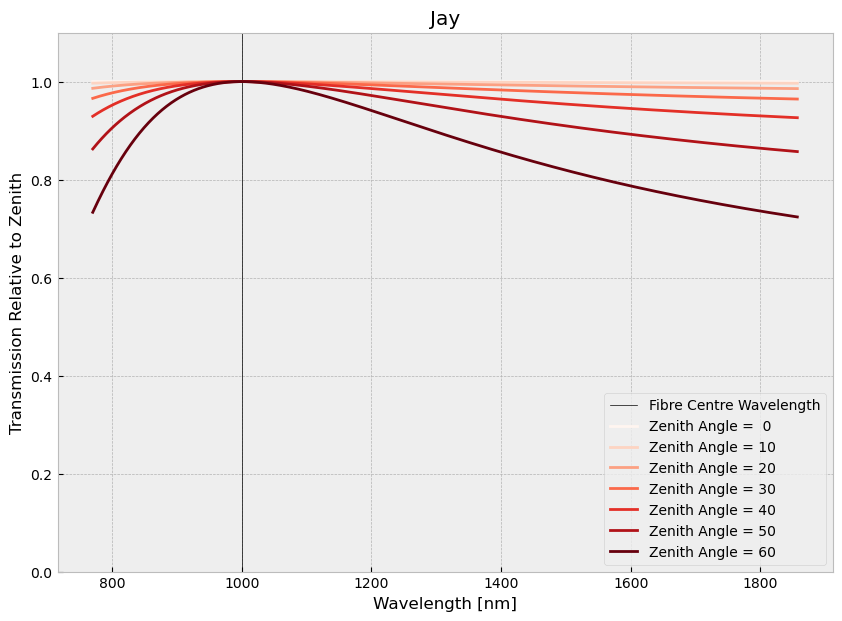

In [3]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.52 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=False, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot(analysis.input_parameters,analysis.output_parameters,conditions,normalise="zenith")

11.5
534.04


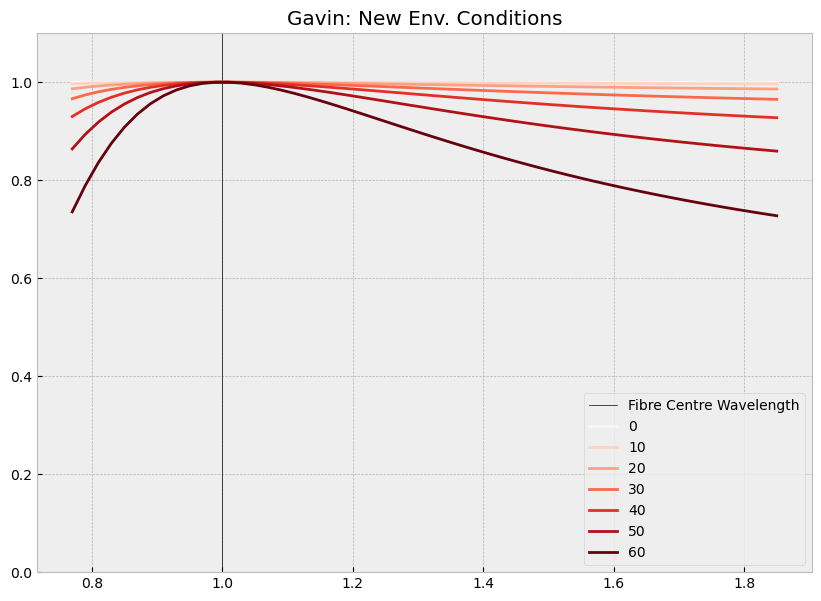

In [4]:
zd=np.arange(0,65,10)
wl =np.arange(0.770,1.857,0.02)
gav.plotall(wl,zd,1.0,apert=0.6, seeing=0.68, title="Gavin: New Env. Conditions")


-10
700


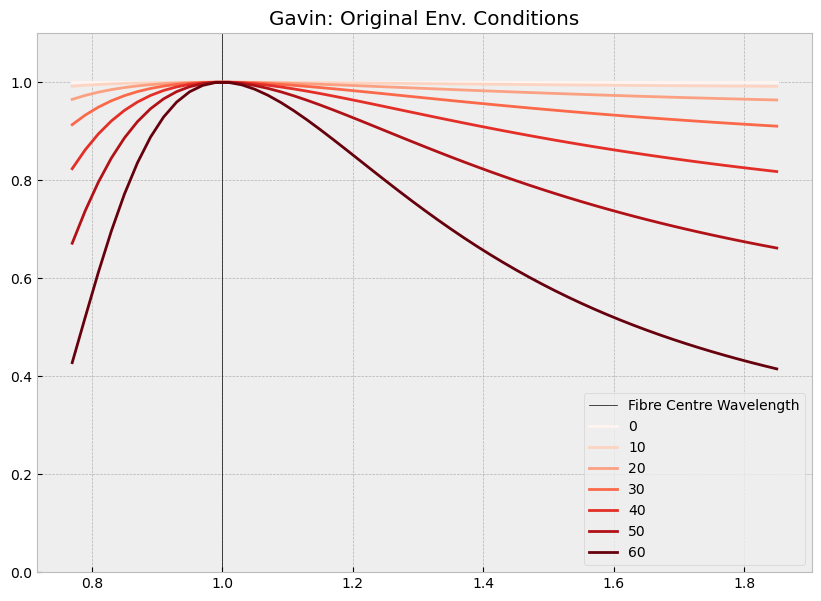

In [5]:
zd=np.arange(0,65,10)
wl =np.arange(0.770,1.857,0.02)
gav.plotall(wl,zd,1.0,apert=0.6,p=700,t=-10,title="Gavin: Original Env. Conditions")

Zenith Angles Used


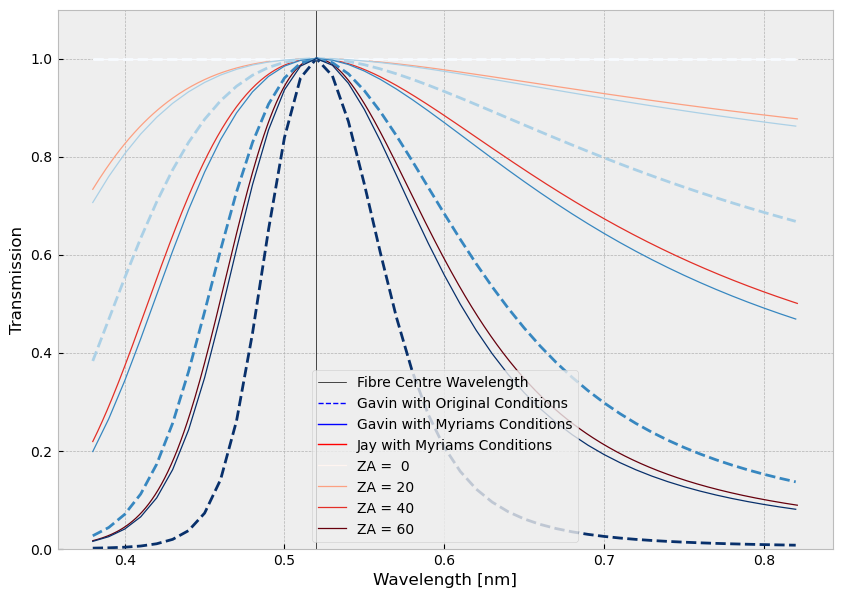

In [6]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','R',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,20,40,60])
analysis.calculate_shifts(fibrecentre_waveref = .52 * u.micron,reposition=True, guide_waveref=0.52 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=False, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)

airmasses=analysis.output_parameters['airmasses']
ZA_range=analysis.input_parameters['ZA_range']
HA_range=analysis.input_parameters['HA_range']

wave_wavelengths=analysis.output_parameters['wave_wavelengths']
fibre_diameter=analysis.output_parameters['fibre_diameter']
wave_transmissions=analysis.output_parameters['wave_transmissions']

fibrecentre_waveref=analysis.input_parameters['fibrecentre_waveref']
guide_waveref=analysis.input_parameters['guide_waveref']
median_FWHM=analysis.input_parameters['median_FWHM']
median_FWHM_lambda=analysis.input_parameters['median_FWHM_lambda']
kolb_factor=analysis.input_parameters['kolb_factor']
regime=analysis.input_parameters['regime']
res=analysis.input_parameters['res']
k_lim=analysis.input_parameters['k_lim']
FWHM_change=analysis.input_parameters['FWHM_change']
scale=analysis.input_parameters['scale']
method=analysis.input_parameters['method']
beta=analysis.input_parameters['beta']
band=analysis.input_parameters['band']
reposition=analysis.input_parameters['reposition']
targ_dec=analysis.input_parameters['targ_dec']

zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift

zenith_transmission = []
for i in range(0,len(zenith_FWHMs)):
    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
    
wcen=.52
zdrange=np.arange(0,65,20)
fig, ax = plt.subplots(figsize=(10,7))
wl =np.arange(0.380,.821,0.01)
apert=0.6
plt.axvline(wcen,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
plt.axhline(1.2,color='blue',linewidth=1,linestyle='--',label='Gavin with Original Conditions')
plt.axhline(1.2,color='blue',linewidth=1,label='Gavin with Myriams Conditions')
plt.axhline(1.2,color='red',linewidth=1,label='Jay with Myriams Conditions')
weights = np.arange(1, len(zdrange)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

for i in range(0,len(wave_transmissions)):
    plt.plot(wave_wavelengths/1000,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1),linewidth=0.9)    
plt.ylabel("Transmission Relative to Zenith")


p=700
t=-10
seeing=0.5

k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linestyle='--')



seeing=0.68
p=534.04
t=11.5


k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linewidth=0.9)
    
    
    
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Transmission")
plt.ylim(0,1.1)
plt.savefig("Comparisonvis.png",dpi=600)


Zenith Angles Used


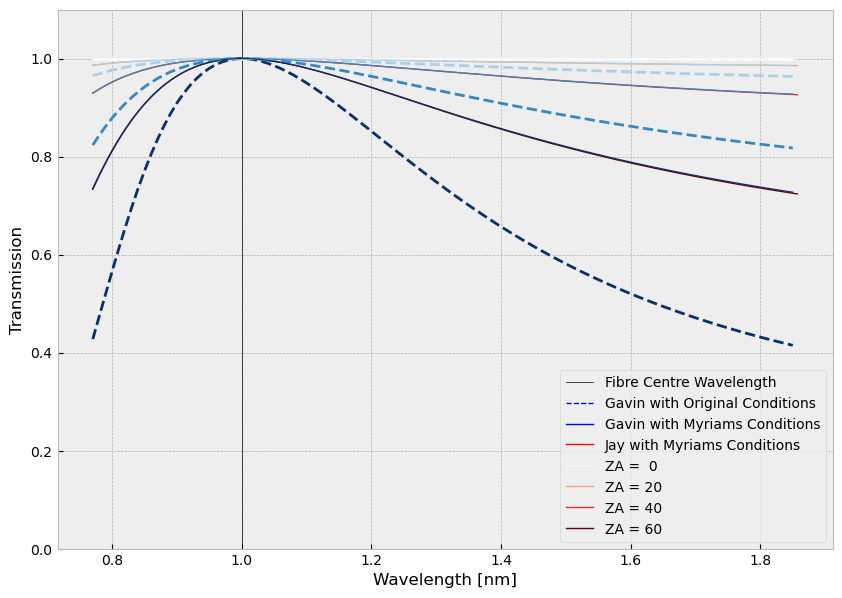

In [7]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,20,40,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.52 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=False, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)

airmasses=analysis.output_parameters['airmasses']
ZA_range=analysis.input_parameters['ZA_range']
HA_range=analysis.input_parameters['HA_range']

wave_wavelengths=analysis.output_parameters['wave_wavelengths']
fibre_diameter=analysis.output_parameters['fibre_diameter']
wave_transmissions=analysis.output_parameters['wave_transmissions']

fibrecentre_waveref=analysis.input_parameters['fibrecentre_waveref']
guide_waveref=analysis.input_parameters['guide_waveref']
median_FWHM=analysis.input_parameters['median_FWHM']
median_FWHM_lambda=analysis.input_parameters['median_FWHM_lambda']
kolb_factor=analysis.input_parameters['kolb_factor']
regime=analysis.input_parameters['regime']
res=analysis.input_parameters['res']
k_lim=analysis.input_parameters['k_lim']
FWHM_change=analysis.input_parameters['FWHM_change']
scale=analysis.input_parameters['scale']
method=analysis.input_parameters['method']
beta=analysis.input_parameters['beta']
band=analysis.input_parameters['band']
reposition=analysis.input_parameters['reposition']
targ_dec=analysis.input_parameters['targ_dec']

zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift

zenith_transmission = []
for i in range(0,len(zenith_FWHMs)):
    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
    
wcen=1
zdrange=np.arange(0,65,20)
fig, ax = plt.subplots(figsize=(10,7))
wl =np.arange(0.77,1.857,0.01)
apert=0.6
plt.axvline(wcen,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
plt.axhline(1.2,color='blue',linewidth=1,linestyle='--',label='Gavin with Original Conditions')
plt.axhline(1.2,color='blue',linewidth=1,label='Gavin with Myriams Conditions')
plt.axhline(1.2,color='red',linewidth=1,label='Jay with Myriams Conditions')
weights = np.arange(1, len(zdrange)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

for i in range(0,len(wave_transmissions)):
    plt.plot(wave_wavelengths/1000,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1),linewidth=1)    
plt.ylabel("Transmission Relative to Zenith")


p=700
t=-10
seeing=0.5

k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linestyle='--')



seeing=0.68
p=534.04
t=11.5


k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linewidth=0.9)
    
    
    
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Transmission")
plt.ylim(0,1.1)
plt.savefig("ComparisonNIR.png",dpi=600)

Zenith Angles Used


(0.0, 2.5)

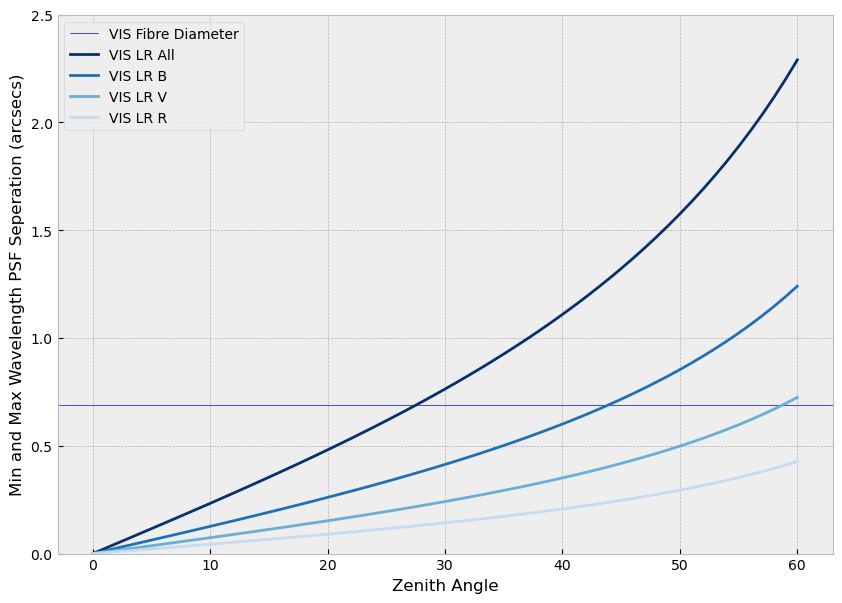

In [8]:
def red_blue_seperation(config):
    seperations=[]
    for i in config:
        Config_regime = ConfigObj('./Architecture_parameters/'+i[0]+'_channel_conf.ini')
        sampling = -int(Config_regime[i[1]]['Bands'][i[2]]['wave_min'])+int(Config_regime[i[1]]['Bands'][i[3]]['wave_max'])
        analysis.load_wave(i[1],i[0],i[2],i[3],sampling * u.nm)
        analysis.calculate_shifts(fibrecentre_waveref = 100 * u.micron, reposition=False, guide_waveref=200 * u.micron)
        seperation=[]
        for o in analysis.output_parameters['shifts']:
            seperation.append(abs(o[0]-o[1]).value)
        seperations.append(seperation)
    return seperations

angles=ZA_range=np.arange(0,61)
analysis=AD_analysis()
analysis.load_airmasses(ZA_range=angles)


NIR_LR=[["NIR","LR","IY","H"],["NIR","LR","J","J"],["NIR","LR","IY","IY"],["NIR","LR","H","H"]]

VIS_LR=[["VIS","LR","B","R"],["VIS","LR","B","B"],["VIS","LR","V","V"],["VIS","LR","R","R"]]


NIR_LR_sep=red_blue_seperation(NIR_LR)

VIS_LR_sep=red_blue_seperation(VIS_LR)


weights4 = np.arange(0, 4+1)
norm4 = mpl.colors.Normalize(vmin=min(weights4), vmax=max(weights4))
cmap4_1 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Reds)
cmap4_2 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Blues)



fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.69,color='blue',linewidth=0.5,label='VIS Fibre Diameter')
plt.plot(angles,VIS_LR_sep[0],label="VIS LR All",color=cmap4_2.to_rgba(3+1))
plt.plot(angles,VIS_LR_sep[1],label="VIS LR B",color=cmap4_2.to_rgba(2+1))
plt.plot(angles,VIS_LR_sep[2],label="VIS LR V",color=cmap4_2.to_rgba(1+1))
plt.plot(angles,VIS_LR_sep[3],label="VIS LR R",color=cmap4_2.to_rgba(0+1))

plt.ylabel("Min and Max Wavelength PSF Seperation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)


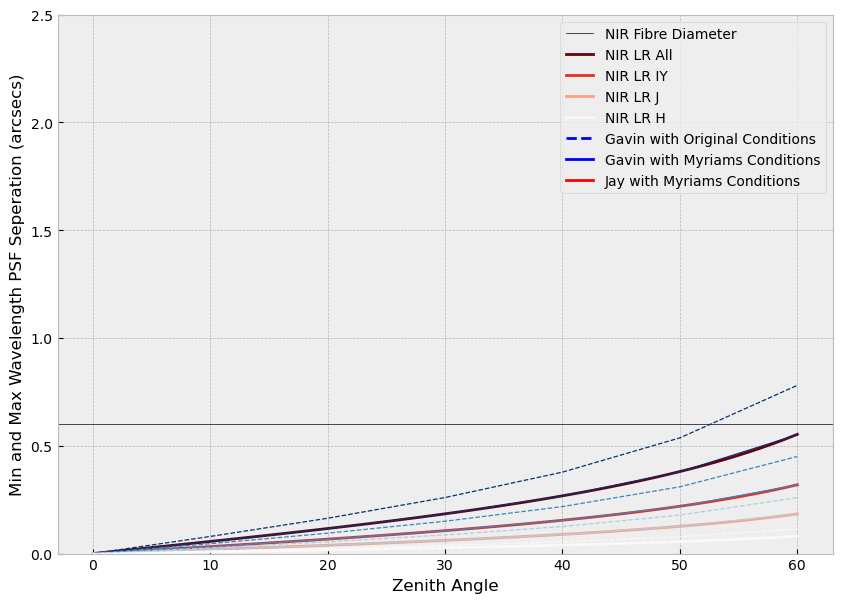

In [9]:
lr5=gav.atmosdisp(0.77,1.063,zd,534.04,11.5,obsalt=3.,water=2.)
lr6=gav.atmosdisp(1.01,1.395,zd,534.04,11.5,obsalt=3.,water=2.)
lr7=gav.atmosdisp(1.42,1.857,zd,534.04,11.5,obsalt=3.,water=2.)
lr8=gav.atmosdisp(0.77,1.857,zd,534.04,11.5,obsalt=3.,water=2.)

lr51=gav.atmosdisp(0.77,1.063,zd,700,-10,obsalt=3.,water=2.)
lr61=gav.atmosdisp(1.01,1.395,zd,700,-10,obsalt=3.,water=2.)
lr71=gav.atmosdisp(1.42,1.857,zd,700,-10,obsalt=3.,water=2.)
lr81=gav.atmosdisp(0.77,1.857,zd,700,-10,obsalt=3.,water=2.)

fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.6,color='black',linewidth=0.5,label='NIR Fibre Diameter')
plt.plot(angles,NIR_LR_sep[0],label="NIR LR All",color=cmap.to_rgba(4))
plt.plot(angles,NIR_LR_sep[2],label="NIR LR IY",color=cmap.to_rgba(3))
plt.plot(angles,NIR_LR_sep[1],label="NIR LR J",color=cmap.to_rgba(2))
plt.plot(angles,NIR_LR_sep[3],label="NIR LR H",color=cmap.to_rgba(1))

plt.plot(zd,lr8,color=cmap2.to_rgba(4),linewidth=0.9)
plt.plot(zd,lr5,color=cmap2.to_rgba(3),linewidth=0.9)
plt.plot(zd,lr6,color=cmap2.to_rgba(2),linewidth=0.9)
plt.plot(zd,lr7,color=cmap2.to_rgba(1),linewidth=0.9)

plt.plot(zd,lr81,color=cmap2.to_rgba(4),linewidth=0.9, linestyle='--')
plt.plot(zd,lr51,color=cmap2.to_rgba(3),linewidth=0.9, linestyle='--')
plt.plot(zd,lr61,color=cmap2.to_rgba(2),linewidth=0.9, linestyle='--')
plt.plot(zd,lr71,color=cmap2.to_rgba(1),linewidth=0.9, linestyle='--')    

plt.axhline(y=3,color='blue',linestyle='--',label='Gavin with Original Conditions')
plt.axhline(y=3,color='blue',label='Gavin with Myriams Conditions')
plt.axhline(y=3,color='red',label='Jay with Myriams Conditions')

plt.ylabel("Min and Max Wavelength PSF Seperation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)
plt.savefig("NIR_sep.png",dpi=600)

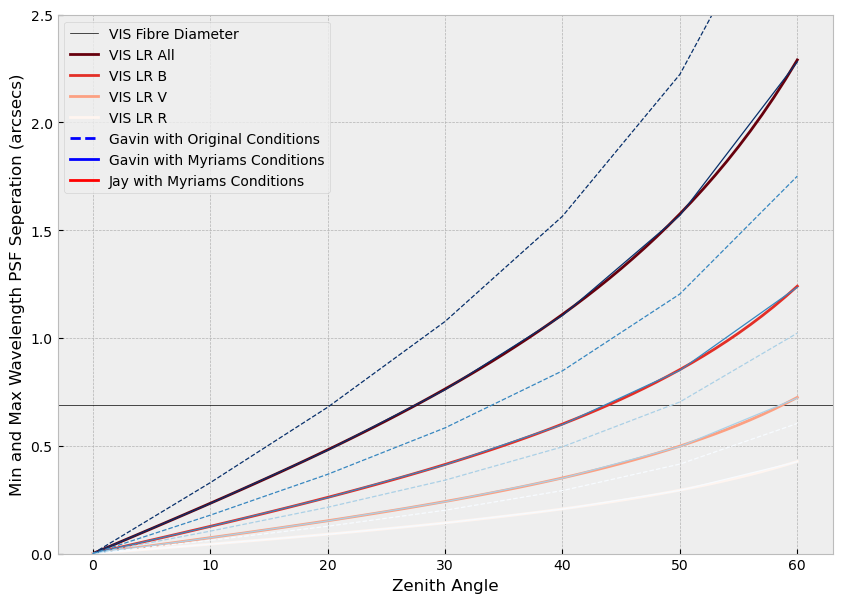

In [10]:
lr1=gav.atmosdisp(0.38,0.497,zd,534.04,11.5,obsalt=3.,water=2.)
lr2=gav.atmosdisp(0.487,0.637,zd,534.04,11.5,obsalt=3.,water=2.)
lr3=gav.atmosdisp(0.627,0.821,zd,534.04,11.5,obsalt=3.,water=2.)
lr4=gav.atmosdisp(0.38,0.821,zd,534.04,11.5,obsalt=3.,water=2.)

lr11=gav.atmosdisp(0.38,0.497,zd,700,-10,obsalt=3.,water=2.)
lr21=gav.atmosdisp(0.487,0.637,zd,700,-10,obsalt=3.,water=2.)
lr31=gav.atmosdisp(0.627,0.821,zd,700,-10,obsalt=3.,water=2.)
lr41=gav.atmosdisp(0.38,0.821,zd,700,-10,obsalt=3.,water=2.)

fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.69,color='black',linewidth=0.5,label='VIS Fibre Diameter')
plt.plot(angles,VIS_LR_sep[0],label="VIS LR All",color=cmap.to_rgba(4))
plt.plot(angles,VIS_LR_sep[1],label="VIS LR B",color=cmap.to_rgba(3))
plt.plot(angles,VIS_LR_sep[2],label="VIS LR V",color=cmap.to_rgba(2))
plt.plot(angles,VIS_LR_sep[3],label="VIS LR R",color=cmap.to_rgba(1))

plt.plot(zd,lr4,color=cmap2.to_rgba(4),linewidth=0.9)
plt.plot(zd,lr3,color=cmap2.to_rgba(1),linewidth=0.9)
plt.plot(zd,lr2,color=cmap2.to_rgba(2),linewidth=0.9)
plt.plot(zd,lr1,color=cmap2.to_rgba(3),linewidth=0.9)

plt.plot(zd,lr41,color=cmap2.to_rgba(4),linewidth=0.9, linestyle='--')
plt.plot(zd,lr31,color=cmap2.to_rgba(1),linewidth=0.9, linestyle='--')
plt.plot(zd,lr21,color=cmap2.to_rgba(2),linewidth=0.9, linestyle='--')
plt.plot(zd,lr11,color=cmap2.to_rgba(3),linewidth=0.9, linestyle='--')    

plt.axhline(y=3,color='blue',linestyle='--',label='Gavin with Original Conditions')
plt.axhline(y=3,color='blue',label='Gavin with Myriams Conditions')
plt.axhline(y=3,color='red',label='Jay with Myriams Conditions')

plt.ylabel("Min and Max Wavelength PSF Seperation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)
plt.savefig("VIS_sep.png",dpi=600)

/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/Mosaic/ADC/ADC Code/Version 2/Gavin Comparison/gavin_atm_disp.py:162: RuntimeWarning: invalid value encountered in arccos
  b=2*np.arccos(a)/np.pi
/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/Mosaic/ADC/ADC Code/Version 2/Gavin Comparison/gavin_atm_disp.py:163: RuntimeWarning: invalid value encountered in sqrt
  c=2*a*np.sqrt(1-a*a)/np.pi


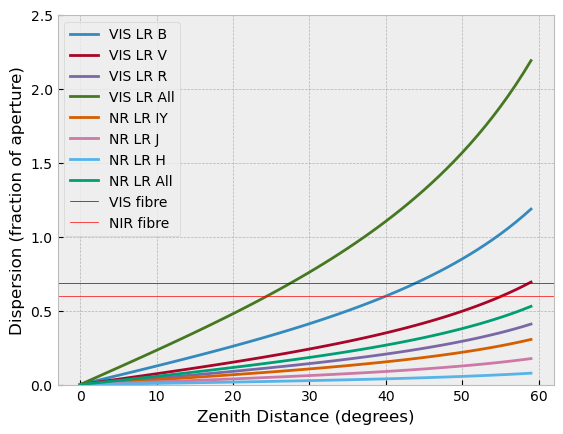

In [11]:
gav.adcplot()

Zenith Angles Used


KeyboardInterrupt: 

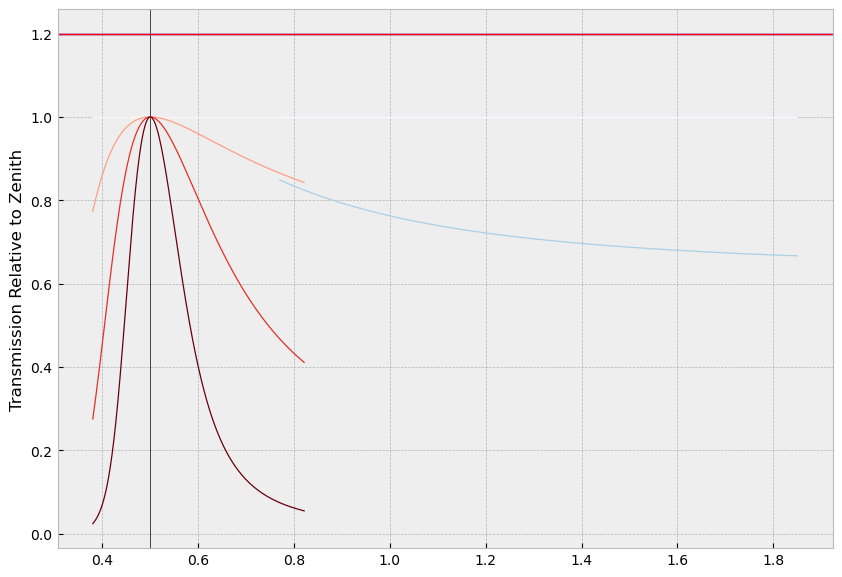

In [14]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','R',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,20,40,60])
analysis.calculate_shifts(fibrecentre_waveref = .5 * u.micron,reposition=True, guide_waveref=0.5 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=False, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)

airmasses=analysis.output_parameters['airmasses']
ZA_range=analysis.input_parameters['ZA_range']
HA_range=analysis.input_parameters['HA_range']

wave_wavelengths=analysis.output_parameters['wave_wavelengths']
fibre_diameter=analysis.output_parameters['fibre_diameter']
wave_transmissions=analysis.output_parameters['wave_transmissions']

fibrecentre_waveref=analysis.input_parameters['fibrecentre_waveref']
guide_waveref=analysis.input_parameters['guide_waveref']
median_FWHM=analysis.input_parameters['median_FWHM']
median_FWHM_lambda=analysis.input_parameters['median_FWHM_lambda']
kolb_factor=analysis.input_parameters['kolb_factor']
regime=analysis.input_parameters['regime']
res=analysis.input_parameters['res']
k_lim=analysis.input_parameters['k_lim']
FWHM_change=analysis.input_parameters['FWHM_change']
scale=analysis.input_parameters['scale']
method=analysis.input_parameters['method']
beta=analysis.input_parameters['beta']
band=analysis.input_parameters['band']
reposition=analysis.input_parameters['reposition']
targ_dec=analysis.input_parameters['targ_dec']

zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift

zenith_transmission = []
for i in range(0,len(zenith_FWHMs)):
    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
    
wcen=.5
zdrange=np.arange(0,65,20)
fig, ax = plt.subplots(figsize=(10,7))
wl =np.arange(0.380,.821,0.01)
apert=0.6
plt.axvline(wcen,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

plt.axhline(1.2,color='blue',linewidth=1,label='Model: Gavin')
plt.axhline(1.2,color='red',linewidth=1,label='Model: Jay')
weights = np.arange(1, len(zdrange)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

for i in range(0,len(wave_transmissions)):
    plt.plot(wave_wavelengths/1000,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1),linewidth=0.9)    
plt.ylabel("Transmission Relative to Zenith")


seeing=0.68
p=534.04
t=11.5


k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linewidth=0.9)
    
    
    
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Transmission Relative to Zenith")
plt.ylim(0,1.1)
plt.title("Fibre Centre = 0.5 microns, VIS All, Constant FWHM")
plt.savefig("Comparison.png",dpi=600)
 

Zenith Angles Used


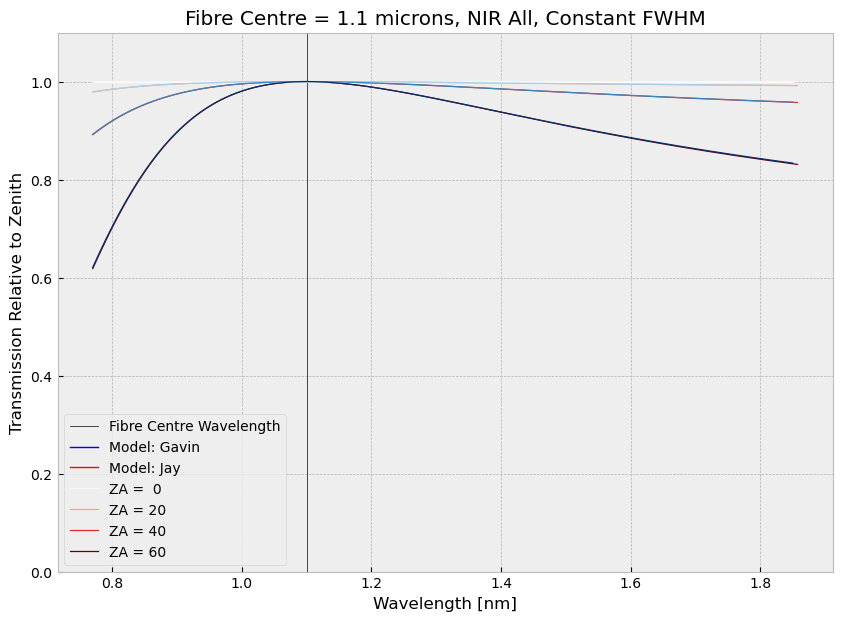

In [20]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,20,40,60])
analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=1.1 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=False, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)

airmasses=analysis.output_parameters['airmasses']
ZA_range=analysis.input_parameters['ZA_range']
HA_range=analysis.input_parameters['HA_range']

wave_wavelengths=analysis.output_parameters['wave_wavelengths']
fibre_diameter=analysis.output_parameters['fibre_diameter']
wave_transmissions=analysis.output_parameters['wave_transmissions']

fibrecentre_waveref=analysis.input_parameters['fibrecentre_waveref']
guide_waveref=analysis.input_parameters['guide_waveref']
median_FWHM=analysis.input_parameters['median_FWHM']
median_FWHM_lambda=analysis.input_parameters['median_FWHM_lambda']
kolb_factor=analysis.input_parameters['kolb_factor']
regime=analysis.input_parameters['regime']
res=analysis.input_parameters['res']
k_lim=analysis.input_parameters['k_lim']
FWHM_change=analysis.input_parameters['FWHM_change']
scale=analysis.input_parameters['scale']
method=analysis.input_parameters['method']
beta=analysis.input_parameters['beta']
band=analysis.input_parameters['band']
reposition=analysis.input_parameters['reposition']
targ_dec=analysis.input_parameters['targ_dec']

zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
zenith_centre_shift=jay.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
zenith_shifts=jay.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift

zenith_transmission = []
for i in range(0,len(zenith_FWHMs)):
    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
    
wcen=1.1
zdrange=np.arange(0,65,20)
fig, ax = plt.subplots(figsize=(10,7))
wl =np.arange(0.77,1.857,0.01)
apert=0.6
plt.axvline(wcen,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

plt.axhline(1.2,color='blue',linewidth=1,label='Model: Gavin')
plt.axhline(1.2,color='red',linewidth=1,label='Model: Jay')
weights = np.arange(1, len(zdrange)+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

for i in range(0,len(wave_transmissions)):
    plt.plot(wave_wavelengths/1000,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1),linewidth=0.9)    
plt.ylabel("Transmission Relative to Zenith")


seeing=0.68
p=534.04
t=11.5


k=0
for i in zdrange:
    tp = []
    for j in wl:
        tp.append(gav.wavethrough(wcen,j,i,apert=apert,seeing=seeing,p=p,t=t))
    tt = np.asarray(tp)
    if (k == 0):
        t0 = tt
    k = k + 1
    plt.plot(wl,tt/t0,color=cmap2.to_rgba(k),linewidth=0.9)
    
    
    
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Transmission Relative to Zenith")
plt.ylim(0,1.1)
plt.title("Fibre Centre = 1.1 microns, NIR All, Constant FWHM")
plt.savefig("Comparison.png",dpi=600)
 